In [144]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any

In [145]:
#TODO dynamic fields based on date
#TODO array should be same length

In [146]:
class HydCal(BaseModel):
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float]
    preamp_gain: int
    ds: Any = None

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v: List[float], info: ValidationInfo):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        self.ds = xr.Dataset(
        data_vars={
            "sensitivity": (["frequency"], self.sens),
        },
        coords={
            "frequency": self.frequencies,
        },
        attrs={
            "model": self.model,
            "serial number": self.sn,
            "calibration date": self.cal_date,
            "preamp_gain": self.preamp_gain,
        }
        )


In [153]:
hyd = HydCal(
    asset_id="ATOSU-58324-00014",
    model="SB35-ETH",
    sn=1270,
    cal_date=datetime(2023,3,1),
    frequencies = [13.5, 27.1, 40.6, 54.1, 67.7, 81.2, 94.7, 108.3, 121.8, 135.3, 148.8, 162.4, 175.9, 189.4, 200.0, 30_000],
    sens=[-168.1, -169.4, -170.7, -171.4, -171.4, -171.8, -170.2, -172.6, -174.0, -172.8, -170.7, -170.1, -172.1, -174.9, -177.0, -177],
    preamp_gain=30,
    )

hyd.make_ndarray()

In [154]:
hyd.cal_date

'2023-03-01T00:00:00.000000Z'

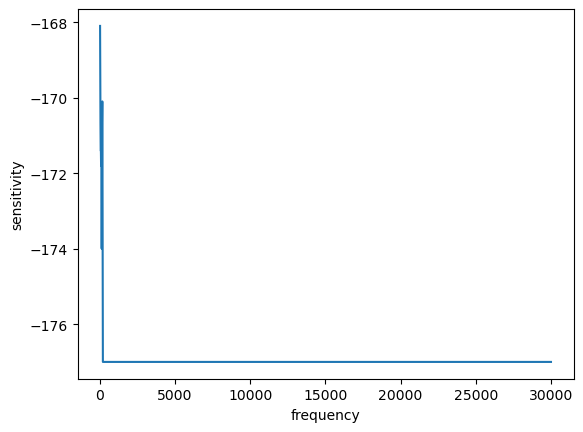

In [155]:
hyd.ds.sensitivity.plot()

In [157]:
hyd.ds.to_netcdf("../metadata/cals/test_cal.nc")